<a href="https://colab.research.google.com/github/Lufec/Brazil_Airports_Graph_Analysis/blob/main/Redes_Artistas_Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autor: Luiz Fernando Carbonera Filho

# Análise de co-ocorrência de Artistas em playlists do Spotify

In [ ]:
#Mounts Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Dados disponibilizados pelo desafio do Kaggle

https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge

In [ ]:
#!unzip /content/drive/MyDrive/Redes/spotify_million_playlist_dataset.zip -d /content/drive/MyDrive/Redes/extracted/

In [ ]:
import pandas as pd
import numpy as np
import json
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from collections import Counter

## Leitura dos dados

Algoritmo de leitura dos arquivos .json gerados pelo competidor vasInk

https://github.com/vaslnk/Spotify-Song-Recommendation-ML/blob/master/EDA.ipynb

In [ ]:
#Read in json splice and transform into a playlist level dataframe
start = 10000
end = 11000
path = '/content/drive/MyDrive/Redes/extracted/data/mpd.slice.' + str(start) + "-" + str(end-1) + '.json'
d = json.load(open(path, 'r'))
thisSlice = pd.DataFrame.from_dict(d['playlists'], orient='columns')



In [ ]:
songPlaylistArray = []
for index, row in thisSlice.iterrows():
    for track in row['tracks']:
        songPlaylistArray.append([ track['artist_name'], row['pid']])
songPlaylist = pd.DataFrame(songPlaylistArray, columns=['artist_name','pid'])

print(songPlaylist.shape)
songPlaylist.head(10)   

(66648, 2)


artist_name    pid
0            Coldplay  10000
1            Coldplay  10000
2               Sting  10000
3              Prince  10000
4              Prince  10000
5              Prince  10000
6            Babyface  10000
7            Babyface  10000
8  Heavy D & The Boyz  10000
9         Keith Sweat  10000

Correção necessária para a execução do algoritmo. Caractere "$" é considerado especial para certos algoritmos

In [ ]:
songPlaylist['artist_name'] = songPlaylist['artist_name'].apply(lambda x: x.replace('$', 'S'))

## Construção do dicionário entre artistas e seus respectivos pesos

Primeiro, construir um dicionário de valores nulos. Primeira chave é o nome de um artista X. Seu valor é um dicionário que contém como chave o nome dos demais artistas. 

Portanto, a chamada artist_lists['Beyonce']['Ed Sheeran'] representa o número de vezes que ambos artistas encontraram-se em uma mesma playlist.

In [ ]:
artist_relation = {}
artist_lists = songPlaylist['artist_name'].unique()

for name1 in artist_lists:
    artist_count = {}
    for name2 in artist_lists:
        if name1 != name2:
            artist_count[name2] = 0
    artist_relation[name1] = artist_count

Dada a questão do tamanho dos dados e de tempo computacional, o número de playlists deve ser limitada. Foi gerada para a análise casos de 20 playlists e 100 playlists.

In [ ]:
#pid_list = songPlaylist['pid'].unique()
pid_list = range(10000,10100)

Primeira iteração é sobre cada playlist (pid).

Segunda iteração é sobre as chaves das relações dos artistas.
O peso é atualizado para cada ocorrência de dois artistas específicos estarem em uma mesma playlist.

Caso seja desejado analisar a ocorrência de um mesmo artista em uma playlist, o trecho comentado deve ser descomentado. Esse caso não foi considerado devido a necessidade de uma das métricas (eigenvector) não possuir self-loops .

In [ ]:
for pid in pid_list:
    temp = songPlaylist.loc[songPlaylist['pid'] == pid]
    artist_values = temp['artist_name'].value_counts().to_dict()
    for name1 in artist_values:
        for name2 in artist_values:
            if name1 == name2:
                #artist_relation[name1][name2] += artist_values[name2]
                continue
            else:
                artist_relation[name1][name2] += 1

Filtragem dos casos do dicionário em que dois artistas não possuem nenhuma playlist em comum (peso 0). Novo dicionário é gerado excluindo esses casos.

In [ ]:
artists_new = {}
for a1 in artist_relation:
    newDict =  {key:val for key, val in artist_relation[a1].items() if val != 0}
    artists_new[a1] = newDict

## Construção do grafo

In [ ]:
import networkx as nx

In [ ]:
G = nx.Graph()

Leitura do dicionário para geração dos nós e das arestas.

In [ ]:
for a1 in artists_new:
    G.add_node(a1)

for a1 in artists_new:
    for a2 in artists_new[a1]:
        G.add_edge(a1,a2,weight = artists_new[a1][a2])
       

Dado que é desejado analisar um grafo único, foi gerado o maior subgrafo conectado do caso original.

In [ ]:
g = nx.subgraph(G, sorted(nx.connected_components(G), key=len, reverse=True)[0])

## Métricas

# Excentricidade

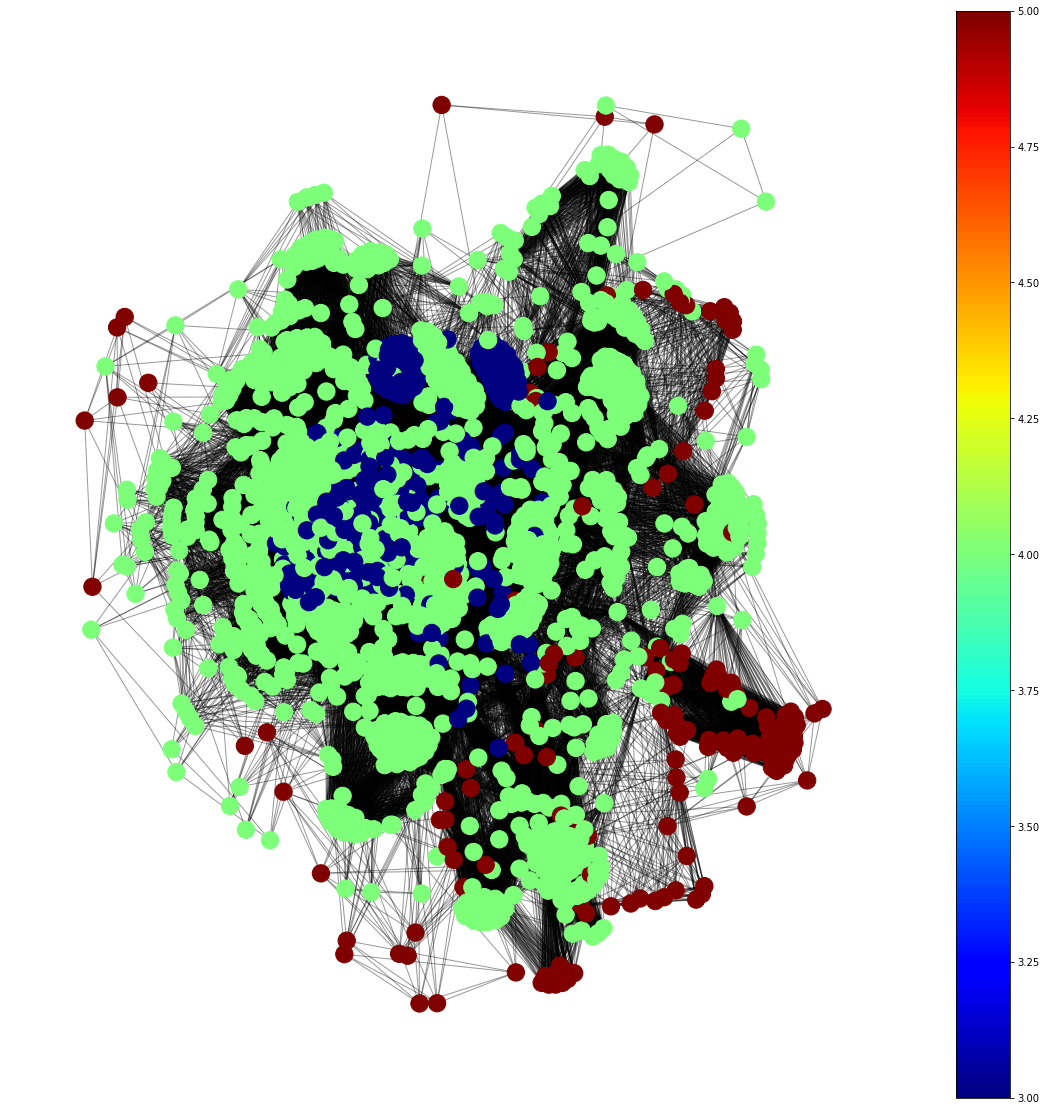

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,20))

# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)
# color of nodes based on eccentricity
color = list(dict(nx.eccentricity(g)).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax)

plt.axis("off")
plt.colorbar(nodes)
plt.savefig('/content/drive/MyDrive/Redes/results/100/eccentricity.png', transparent=True,dpi=300)
plt.show()

Observa-se que a excentricidade de todos os nós varia entre 3 a 5.

## Diâmetro

In [ ]:
# the diameter of networks is the maximum eccentricy
diameter = nx.diameter(g)
print("Diameter of network (g): {}".format(diameter))

Diameter of network (g): 5


## Periferia

A seguinte lista de artistas são aqueles cuja excentricidade é igual ao diâmetro da rede, portanto são os pontos mais externos da rede.

In [ ]:
# the periphery of a network is a set of all nodes whose eccentriciy is equals the diameter
nx.periphery(g)

['Björk',
 'Travis Tritt',
 'Collin Raye',
 'Iris DeMent',
 'Brian Johnson',
 'Hank Williams, Jr.',
 'Chimney Choir',
 'Hugh Bob and the Hustle',
 'BJ Putnam',
 'Switchfoot',
 'Lauren Daigle',
 'MiMS',
 'Emancipator',
 'Duvall',
 'Phaeleh',
 'North Point InsideOut',
 'Matt Maher',
 'Whiskey Myers',
 'Slow Dancing Society',
 'Gnarls Barkley',
 'Drive-By Truckers',
 'Reckless Kelly',
 'Waylon Jennings',
 'Toad The Wet Sprocket',
 'The Welcome Wagon',
 'Boom Clap Bachelors',
 'Charles Kelley',
 'Travis Cottrell',
 'Shooter Jennings',
 'Jars Of Clay',
 'Patrick Lee',
 'Jillian Ann',
 'Alabama',
 'Tonic',
 'Lance Skiiiwalker',
 'Bifrost Arts',
 'Jon Foreman',
 'Nichole Nordeman',
 'Tye Tribbett',
 'Jonathan Thulin',
 'Gungor',
 'Rick Pino',
 'John Wilds',
 'Pat Green',
 'Matt Stinton',
 'Sufjan Stevens',
 "Rose's Pawn Shop",
 'Mosaic MSC',
 'Shane & Shane',
 'All Sons & Daughters',
 'Bethel Music',
 'Desperation Band',
 'Turnpike Troubadours',
 'Brandon Jenkins',
 'Discover America',
 'Jona

## Raio

In [ ]:
# the radius of a network is the minimum eccentricity
radius = nx.radius(g)
print("Radius of network(g): {}".format(radius))

Radius of network(g): 3


## Centro

Já esses são os artistas no centro da rede. Indicativo de proximidade de conexão entre todos os elementos da rede.

In [ ]:
# the center of a network is a set all nodes whose eccentricity equal the radius
nx.center(g)

['Young Money',
 'Tech N9ne Collabos',
 'Nico & Vinz',
 'DJ Khaled',
 'Imagine Dragons',
 'M83',
 'Heart',
 'Faith Hill',
 'You Me At Six',
 'OMI',
 'Filter',
 'Feist',
 'Jeremih',
 'Billy Joel',
 'The Struts',
 'Fetty Wap',
 'Major Lazer',
 'Fabolous',
 'John Mayer',
 'Ariana Grande',
 'Jessie Ware',
 'Marion',
 '2 Chainz',
 'Enation',
 'The Vamps',
 'Brian McKnight',
 'Evanescence',
 'DJ Snake',
 'Ingrid Michaelson',
 'A Great Big World',
 'Lauren Christy',
 'Sam Smith',
 'Tech N9ne',
 'Juris',
 'Counting Crows',
 'Chance The Rapper',
 'Ne-Yo',
 'Wiz Khalifa',
 'Ginuwine',
 'Big K.R.I.T.',
 'Taylor Swift',
 'McFly',
 'The London Film Score Orchestra',
 'Rivermaya',
 'Nicki Minaj',
 'Henrik Måwe',
 'Wolfmother',
 'Lisa Loeb',
 'Michael Andrews',
 'Blackstreet',
 'Demi Lovato',
 'The Fray',
 'Lady Antebellum',
 'Moonstar88',
 'Kid Cudi',
 'Whigfield',
 'T.I.',
 'Survivor',
 'Rihanna',
 'Future',
 'Johnny Cash',
 'John Legend',
 'Gucci Mane',
 'Dr. Dre',
 'OB OBrien',
 'No Sleep',
 'Lil

# Rank dos nós

## Degree Centrality

Grafo do grau de cada nó

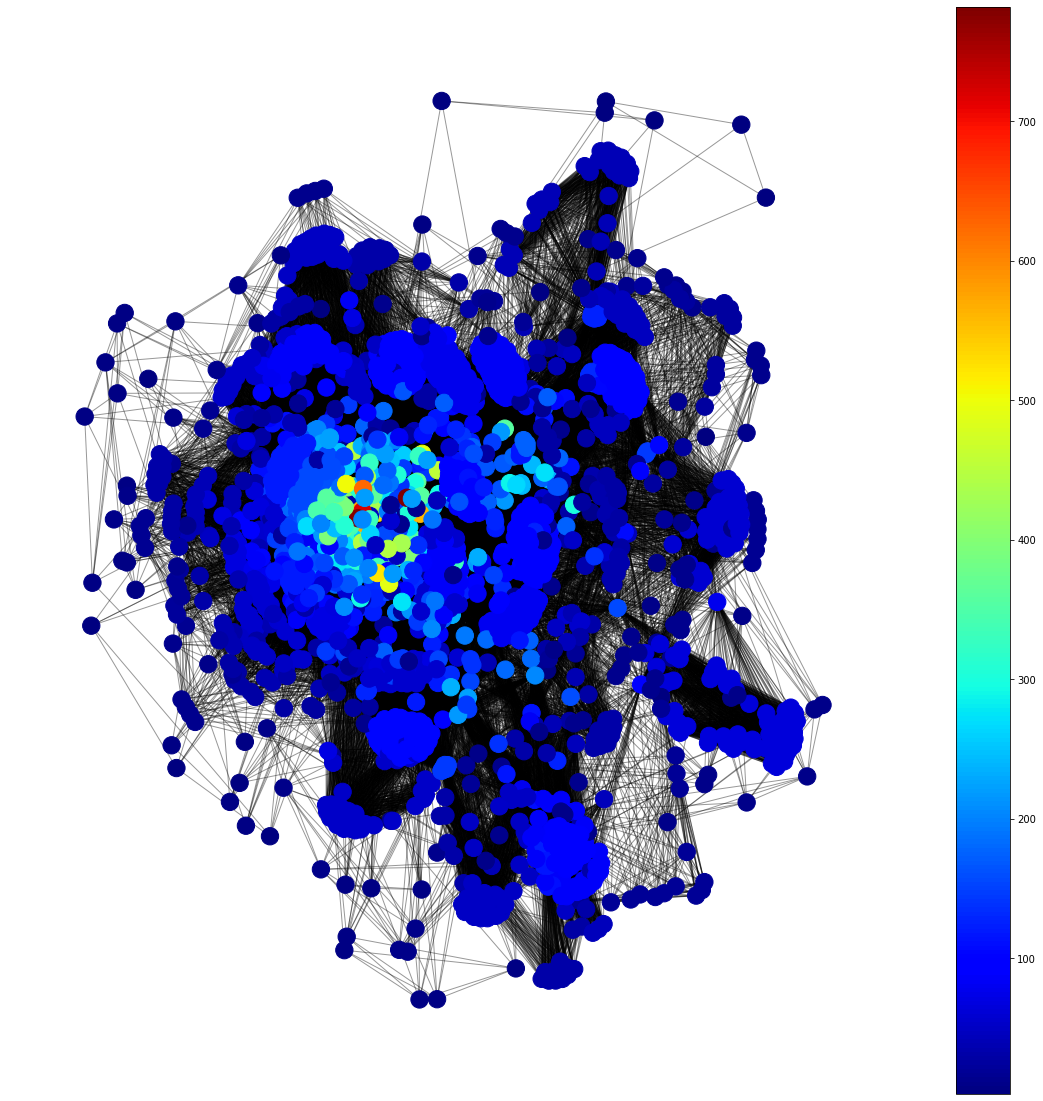

In [ ]:
# the degree of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,20))

# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.degree(g)).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('/content/drive/MyDrive/Redes/results/100/degree.png', transparent=True,dpi=300)
plt.show()

Nota-se que a grande maioria dos nós estão no espectro mais baixo de graus. Apenas certos casos possuem um grau maior, indicando maior ligação entre todas as playlists.

In [ ]:
degree_centrality = nx.degree_centrality(g)

Grafo da Degree Centrality

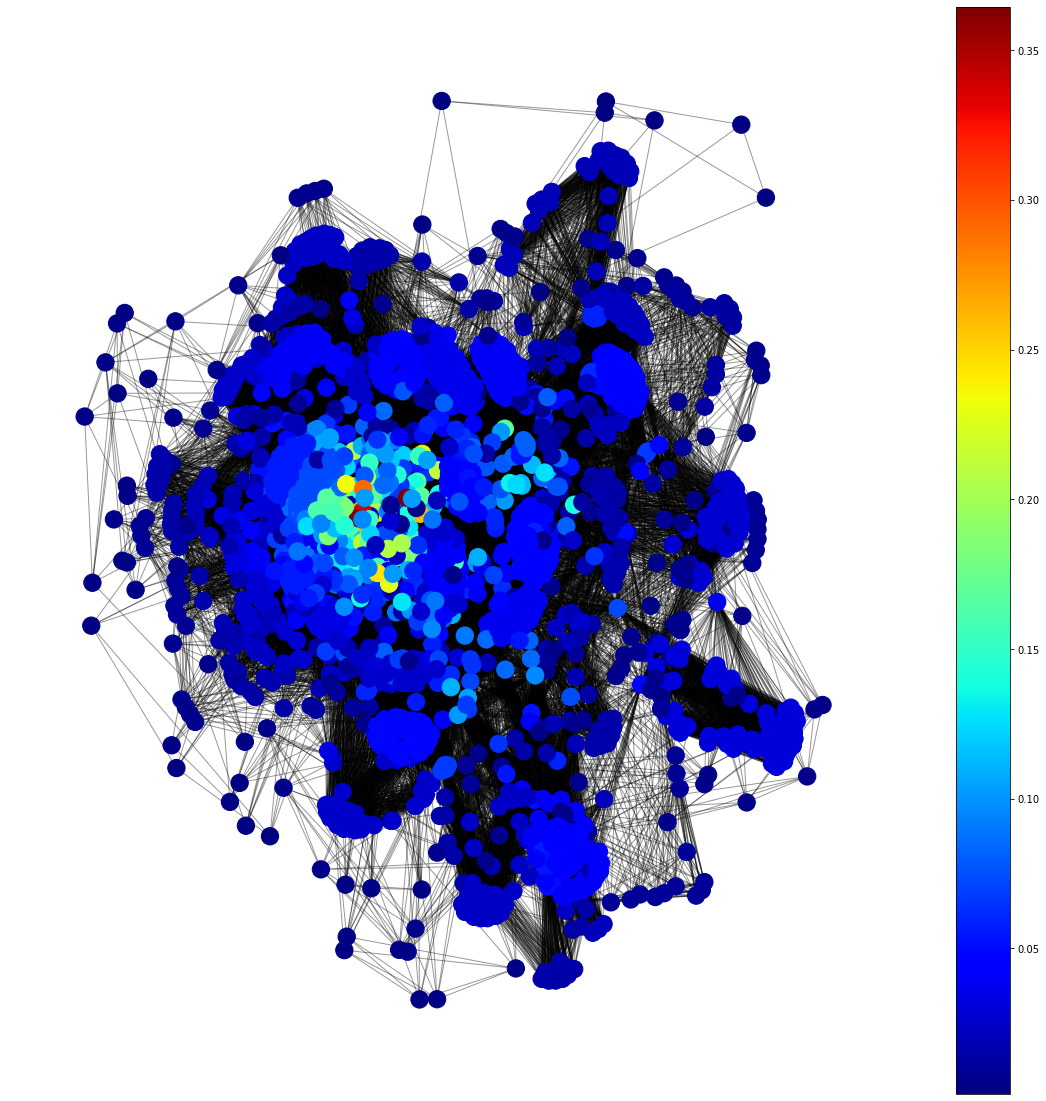

In [ ]:
# the degree centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,20))

# color of nodes
color = list(dict(degree_centrality).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('/content/drive/MyDrive/Redes/results/100/degree_centrality.png', transparent=True,dpi=300)
plt.show()

Novamente, o Degree Centrality indica que apenas certos nós possuem valores relevantes.

In [ ]:
d = Counter(degree_centrality)
for k, v in d.most_common(10):
    print("{} : {}".format(k,v))

Ed Sheeran : 0.3645687645687646
Drake : 0.3622377622377622
The Chainsmokers : 0.3365967365967366
Maroon 5 : 0.29184149184149183
Calvin Harris : 0.2727272727272727
The Weeknd : 0.2680652680652681
Childish Gambino : 0.2662004662004662
Coldplay : 0.2606060606060606
Big Sean : 0.2540792540792541
Chris Brown : 0.2512820512820513


Observa-se que os 10 nós com maior degree centrality são de artistas considerados populares.

## Closeness Centrality

In [ ]:
closeness_centrality = nx.closeness_centrality(g)

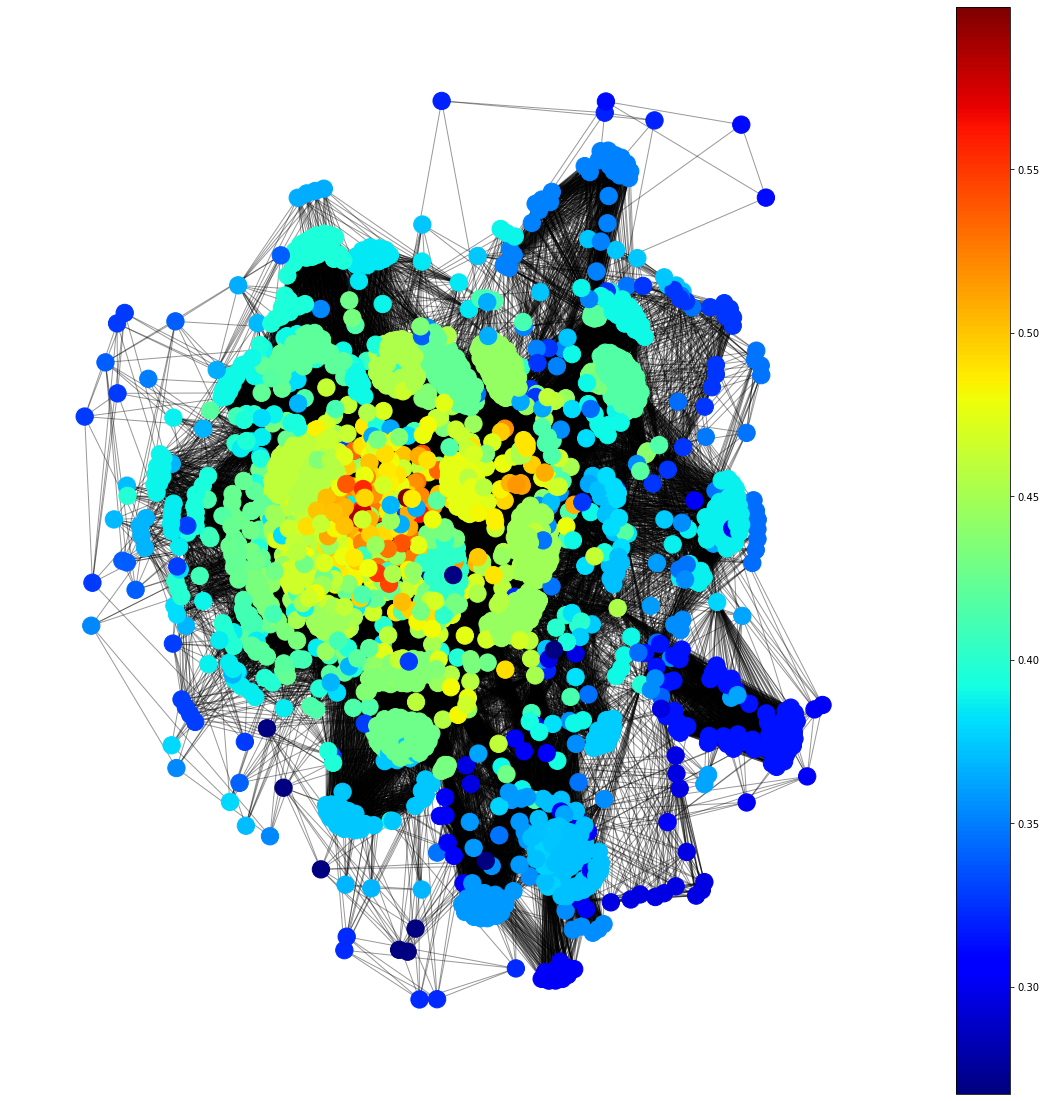

In [ ]:
# the closeness centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,20))

# color of nodes
color = list(dict(closeness_centrality).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

plt.axis("off")
plt.colorbar(nodes)
plt.savefig('/content/drive/MyDrive/Redes/results/1000/closeness_centrality.png', transparent=True,dpi=600)
plt.show()

Nota-se que o grafo apresenta "camadas" dessa métrica. Nesse caso, quanto maior o valor, menor é o caminho médio que o nó precisa atravessar para chegar a todos os pontos. 

In [ ]:
d = Counter(closeness_centrality)
for k, v in d.most_common(10):
    print("{} : {}".format(k,v))

Ed Sheeran : 0.599664523343584
Drake : 0.5867067833698031
The Chainsmokers : 0.5761482675261885
Coldplay : 0.5613713687516357
Martin Garrix : 0.5601984852441891
Calvin Harris : 0.5568535825545171
Maroon 5 : 0.5542635658914729
The Weeknd : 0.5529775715390565
Childish Gambino : 0.5521235521235521
Justin Bieber : 0.5508474576271186


Como esperado, a maioria dos artistas vistos em degree centrality também apresentaram maiores closeness centrality. Por serem populares, seus caminhos até artistas menos conhecidos é menor. 

## Betweenness Centrality

In [ ]:
betweenness_centrality = nx.betweenness_centrality(g)

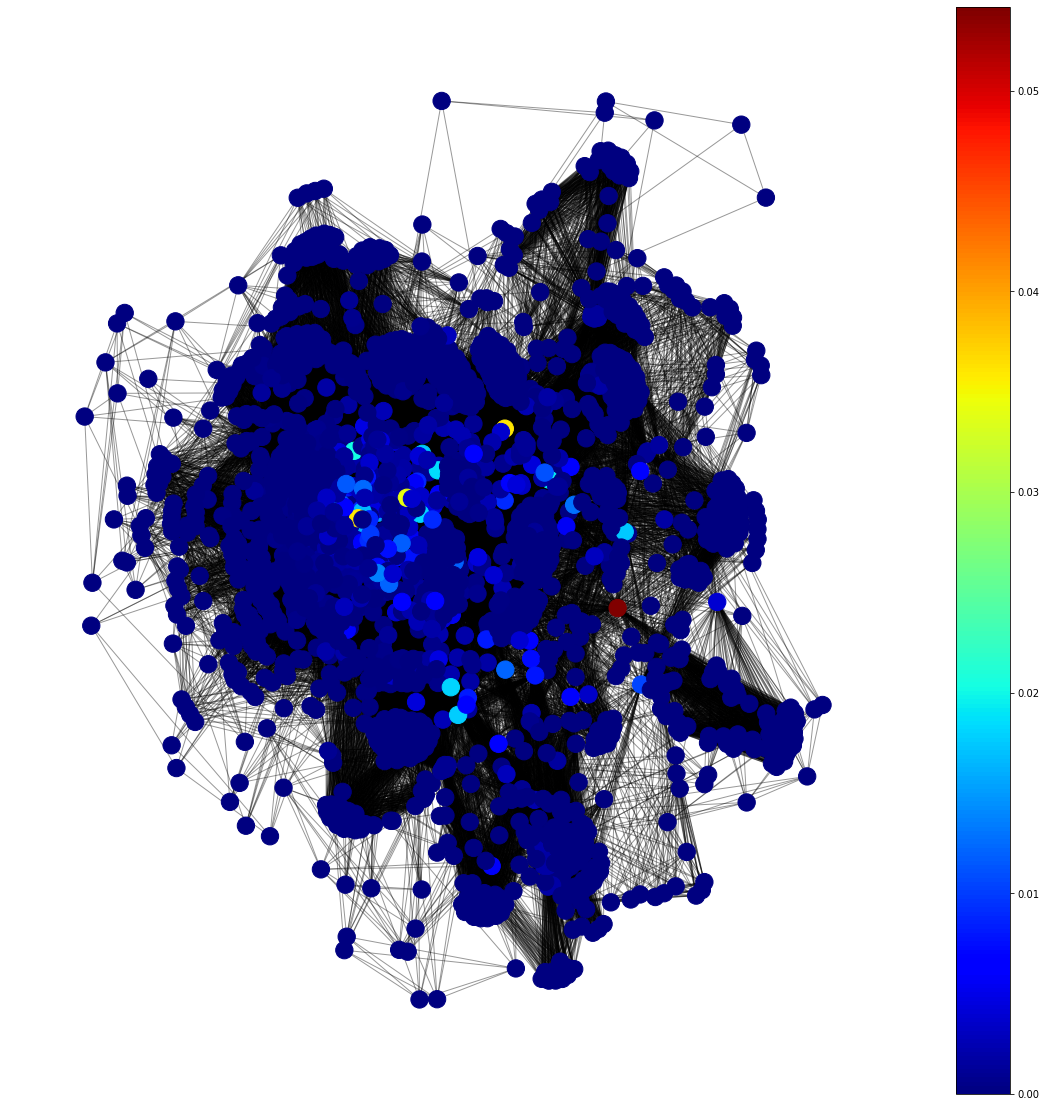

In [ ]:
# the betwenness centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,20))

# color of nodes
color = list(dict(betweenness_centrality).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('/content/drive/MyDrive/Redes/results/100/betweenness_centrality.png', transparent=True,dpi=600)
plt.show()

Esse caso é perceptível que poucos artistas fazem uma "ponte" entre os principais grupos de artistas avaliados. 

In [ ]:
d = Counter(betweenness_centrality)
for k, v in d.most_common(10):
    print("{} : {}".format(k,v))

NEEDTOBREATHE : 0.054184079563274874
Lykke Li : 0.03608098139044027
Drake : 0.035804019170816326
Ed Sheeran : 0.03409102822286511
Daft Punk : 0.020150799834235008
Mumford & Sons : 0.019422629581431504
Mark Ronson : 0.018514412135581904
Kenny Chesney : 0.018030077233335984
Coldplay : 0.01801179143048911
Imagine Dragons : 0.017997830851776617


Agora a lista de artistas sofreu uma certa mudança. Alguns artistas mais bem sucedidos possuem um valor relevante de Betwenness Centrality, porém os artistas que são "mediamente bem sucedidos" (relativamente falando) possuem esse valor alto. Esses casos observa-se a lógica que eles estão tanto nas playlists dos artistas populares quanto na dos artistas de "nicho". Portanto, tornam-se uma ponte importante entre os dois grupos.

## EigenVector Centrality

In [ ]:
eigenvector_centrality = nx.eigenvector_centrality(g, max_iter = 1000, tol = 1e-03)

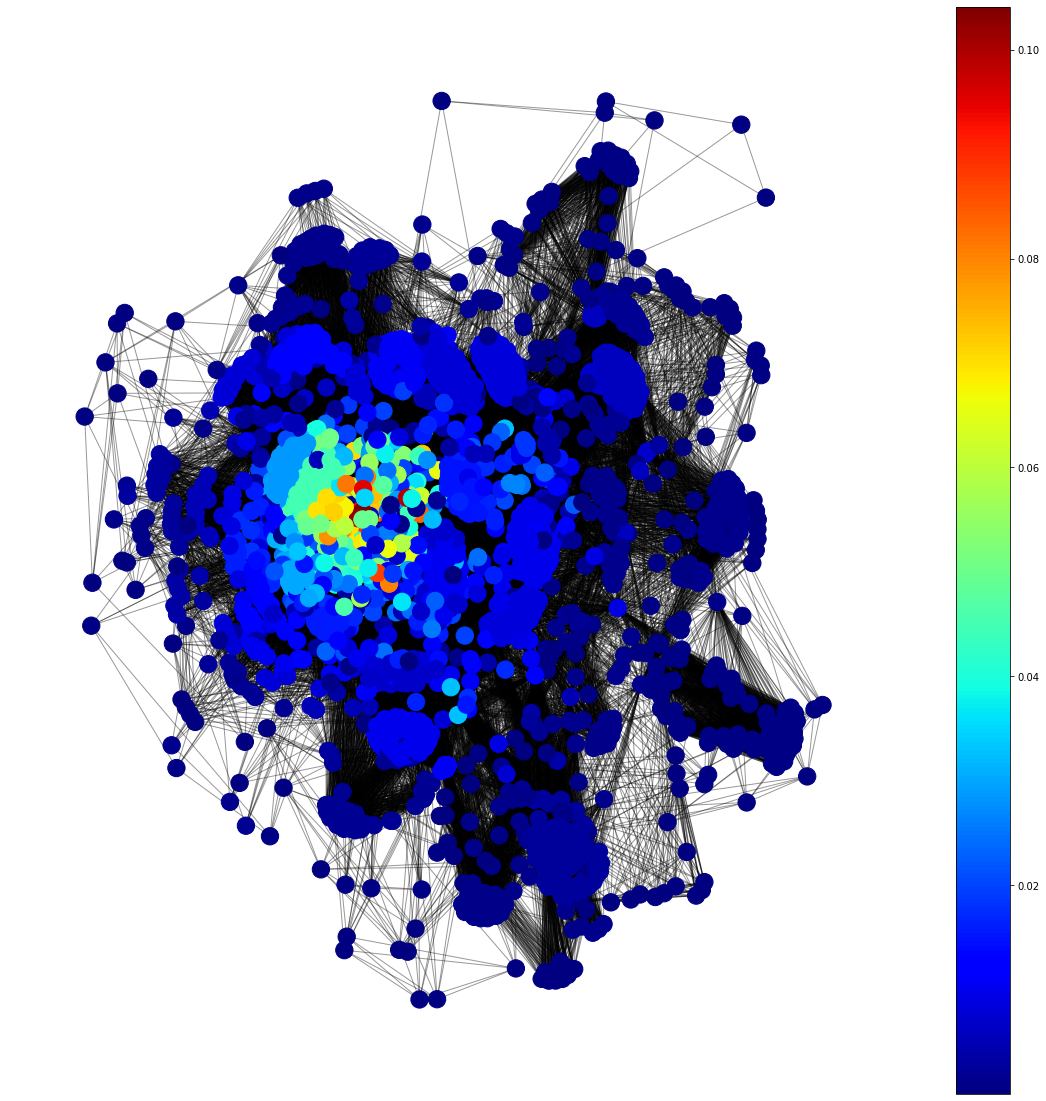

In [ ]:
# the eigenvector centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,20))

# color of nodes
color = list(dict(eigenvector_centrality).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('/content/drive/MyDrive/Redes/results/100/eigenvector_centrality.png', transparent=True,dpi=600)
plt.show()

In [ ]:
d = Counter(eigenvector_centrality)
for k, v in d.most_common(10):
    print("{} : {}".format(k,v))

The Chainsmokers : 0.10413635099487414
Drake : 0.10246282450142041
Ed Sheeran : 0.09917780625764598
Maroon 5 : 0.09495184918848983
The Weeknd : 0.09425722053504362
Childish Gambino : 0.0892482334982978
Calvin Harris : 0.08892222575072466
Justin Bieber : 0.08760969716337737
Fetty Wap : 0.08515091766538163
DJ Khaled : 0.08486699398321076


O comportamento observado nesse grafo é que possuem muitos clusters. A questão do Eigenvector centrality demonstra que certos clusters possuem essa métrica com maior valor. Uma vez que o grupo em si possui alta popularidade e muitas conexões com outros vizinhos, o grupo todo é considerado importante para o grafo. Portanto, observa-se que os maiores valores são compostos pelos artistas mais populares dessa amostra.

## Todas as métricas

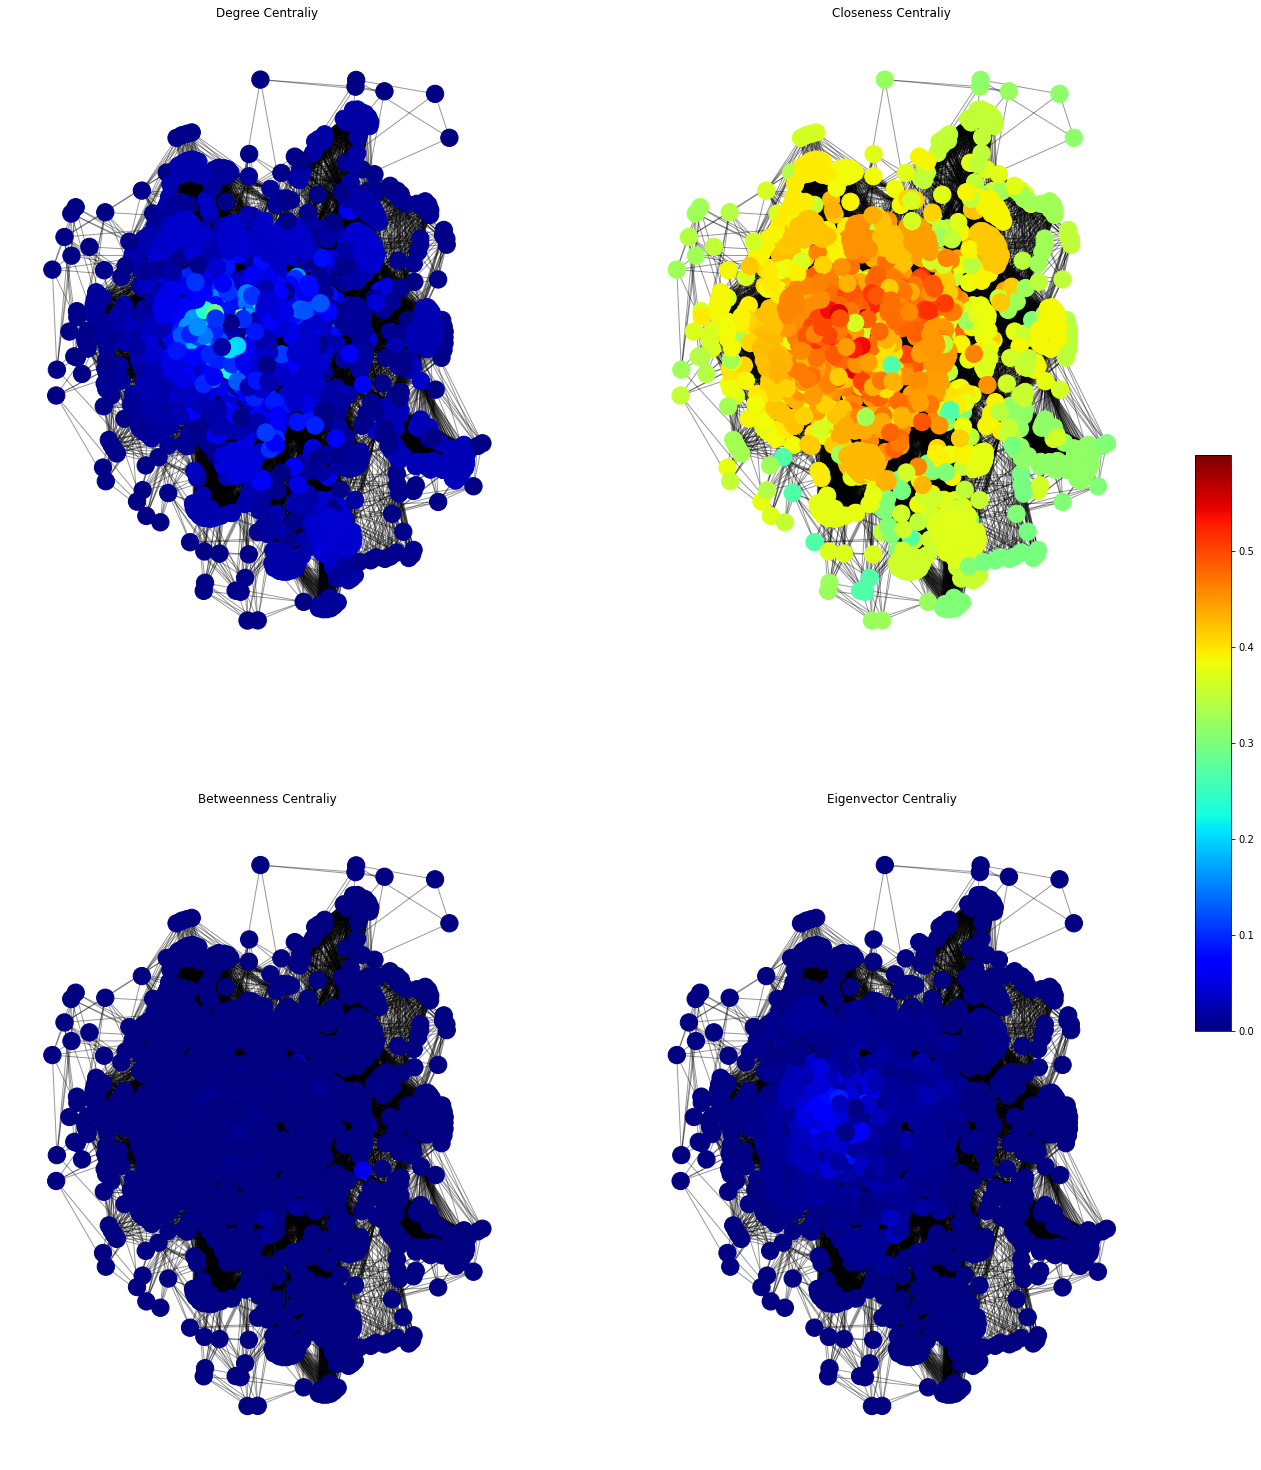

In [ ]:
# the eigenvector centrality of network(g)
fig, ax = plt.subplots(2,2,figsize=(20,20))

# max value of metrics 
max_centrality = max([max([v for k, v in eigenvector_centrality.items()]),
                      max([v for k, v in degree_centrality.items()]),
                      max([v for k, v in closeness_centrality.items()]),
                      max([v for k, v in betweenness_centrality.items()])])


# color of nodes
color_degree = list(dict(degree_centrality).values())
color_closeness = list(dict(closeness_centrality).values())
color_betweenness = list(dict(betweenness_centrality).values())
color_eigenvector = list(dict(eigenvector_centrality).values())

# 
# draw edges
#
# degree centrality
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax[0,0])

# closeness centrality
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax[0,1])

# betweenness centrality
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax[1,0])

# eigenvector centrality
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax[1,1])

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color_degree,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[0,0])
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color_closeness,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[0,1])
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color_betweenness,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[1,0])
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color_eigenvector,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[1,1])


# eliminate axis
ax[0,0].axis("off")
ax[1,0].axis("off")
ax[0,1].axis("off")
ax[1,1].axis("off")

ax[0,0].set_title("Degree Centraliy")
ax[0,1].set_title("Closeness Centraliy")
ax[1,0].set_title("Betweenness Centraliy")
ax[1,1].set_title("Eigenvector Centraliy")


# Create an unique colorbar
# reference: https://stackoverflow.com/questions/60848582/unique-colorbar-at-the-right-of-multiple-subplots
plt.subplots_adjust(bottom=0., right=0.92, top=1.)
cax = plt.axes([0.95, 0.3, 0.025, 0.4])
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=max_centrality))
cbar=plt.colorbar(sm,cax)

plt.savefig('/content/drive/MyDrive/Redes/results/100/alltogether.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

Em suma, observa-se que para Degree Centrality e Eigenvector centrality, os maiores valores são aqueles de um mesmo grupo (dos artistas mais populares). O Closeness centrality possui uma questão de "Camadas", onde é possível identificar os artistas mais populares, os casos medianos e os artistas menos populares. Por fim, o Betweennes Centrality demonstra os artistas mais importantes para a ligação dos grupos, sendo esses artistas os mais populares e os casos medianos. 

# Centrality Distribution

## Histograma

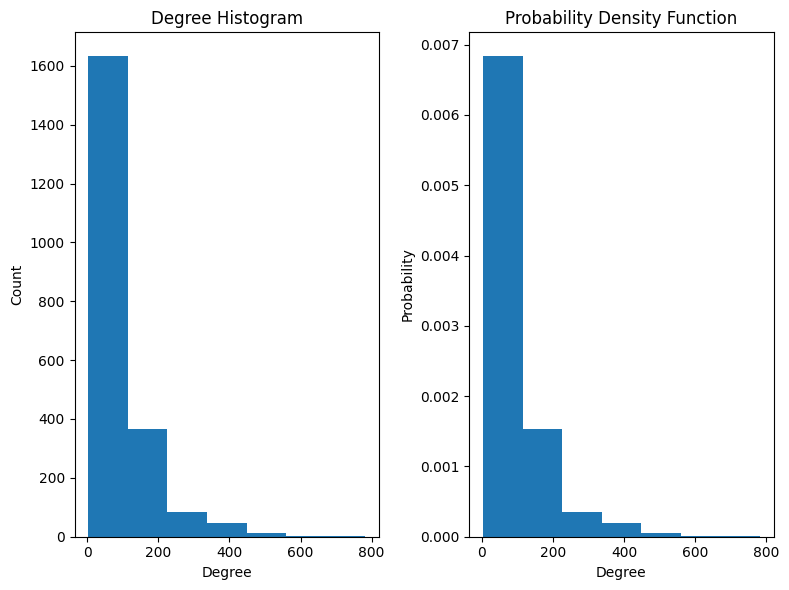

In [ ]:
plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  

fig, ax = plt.subplots(1,2,figsize=(8,6))

# all_data has information about degree_sequence and the width of each bin
all_data = ax[0].hist(degree_sequence,bins=7)
ax[1].hist(degree_sequence,bins=7,density=True)

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")

ax[1].set_title("Probability Density Function")
ax[1].set_ylabel("Probability")
ax[1].set_xlabel("Degree")

plt.tight_layout()
plt.show()

Poucos são os casos de artistas acima de 200 conexões. Outro Indicativo de que as playlists aglomeram mesmos grupos de artistas entre si, com exceções de artistas medianos e populares interligando-os.

## PDF

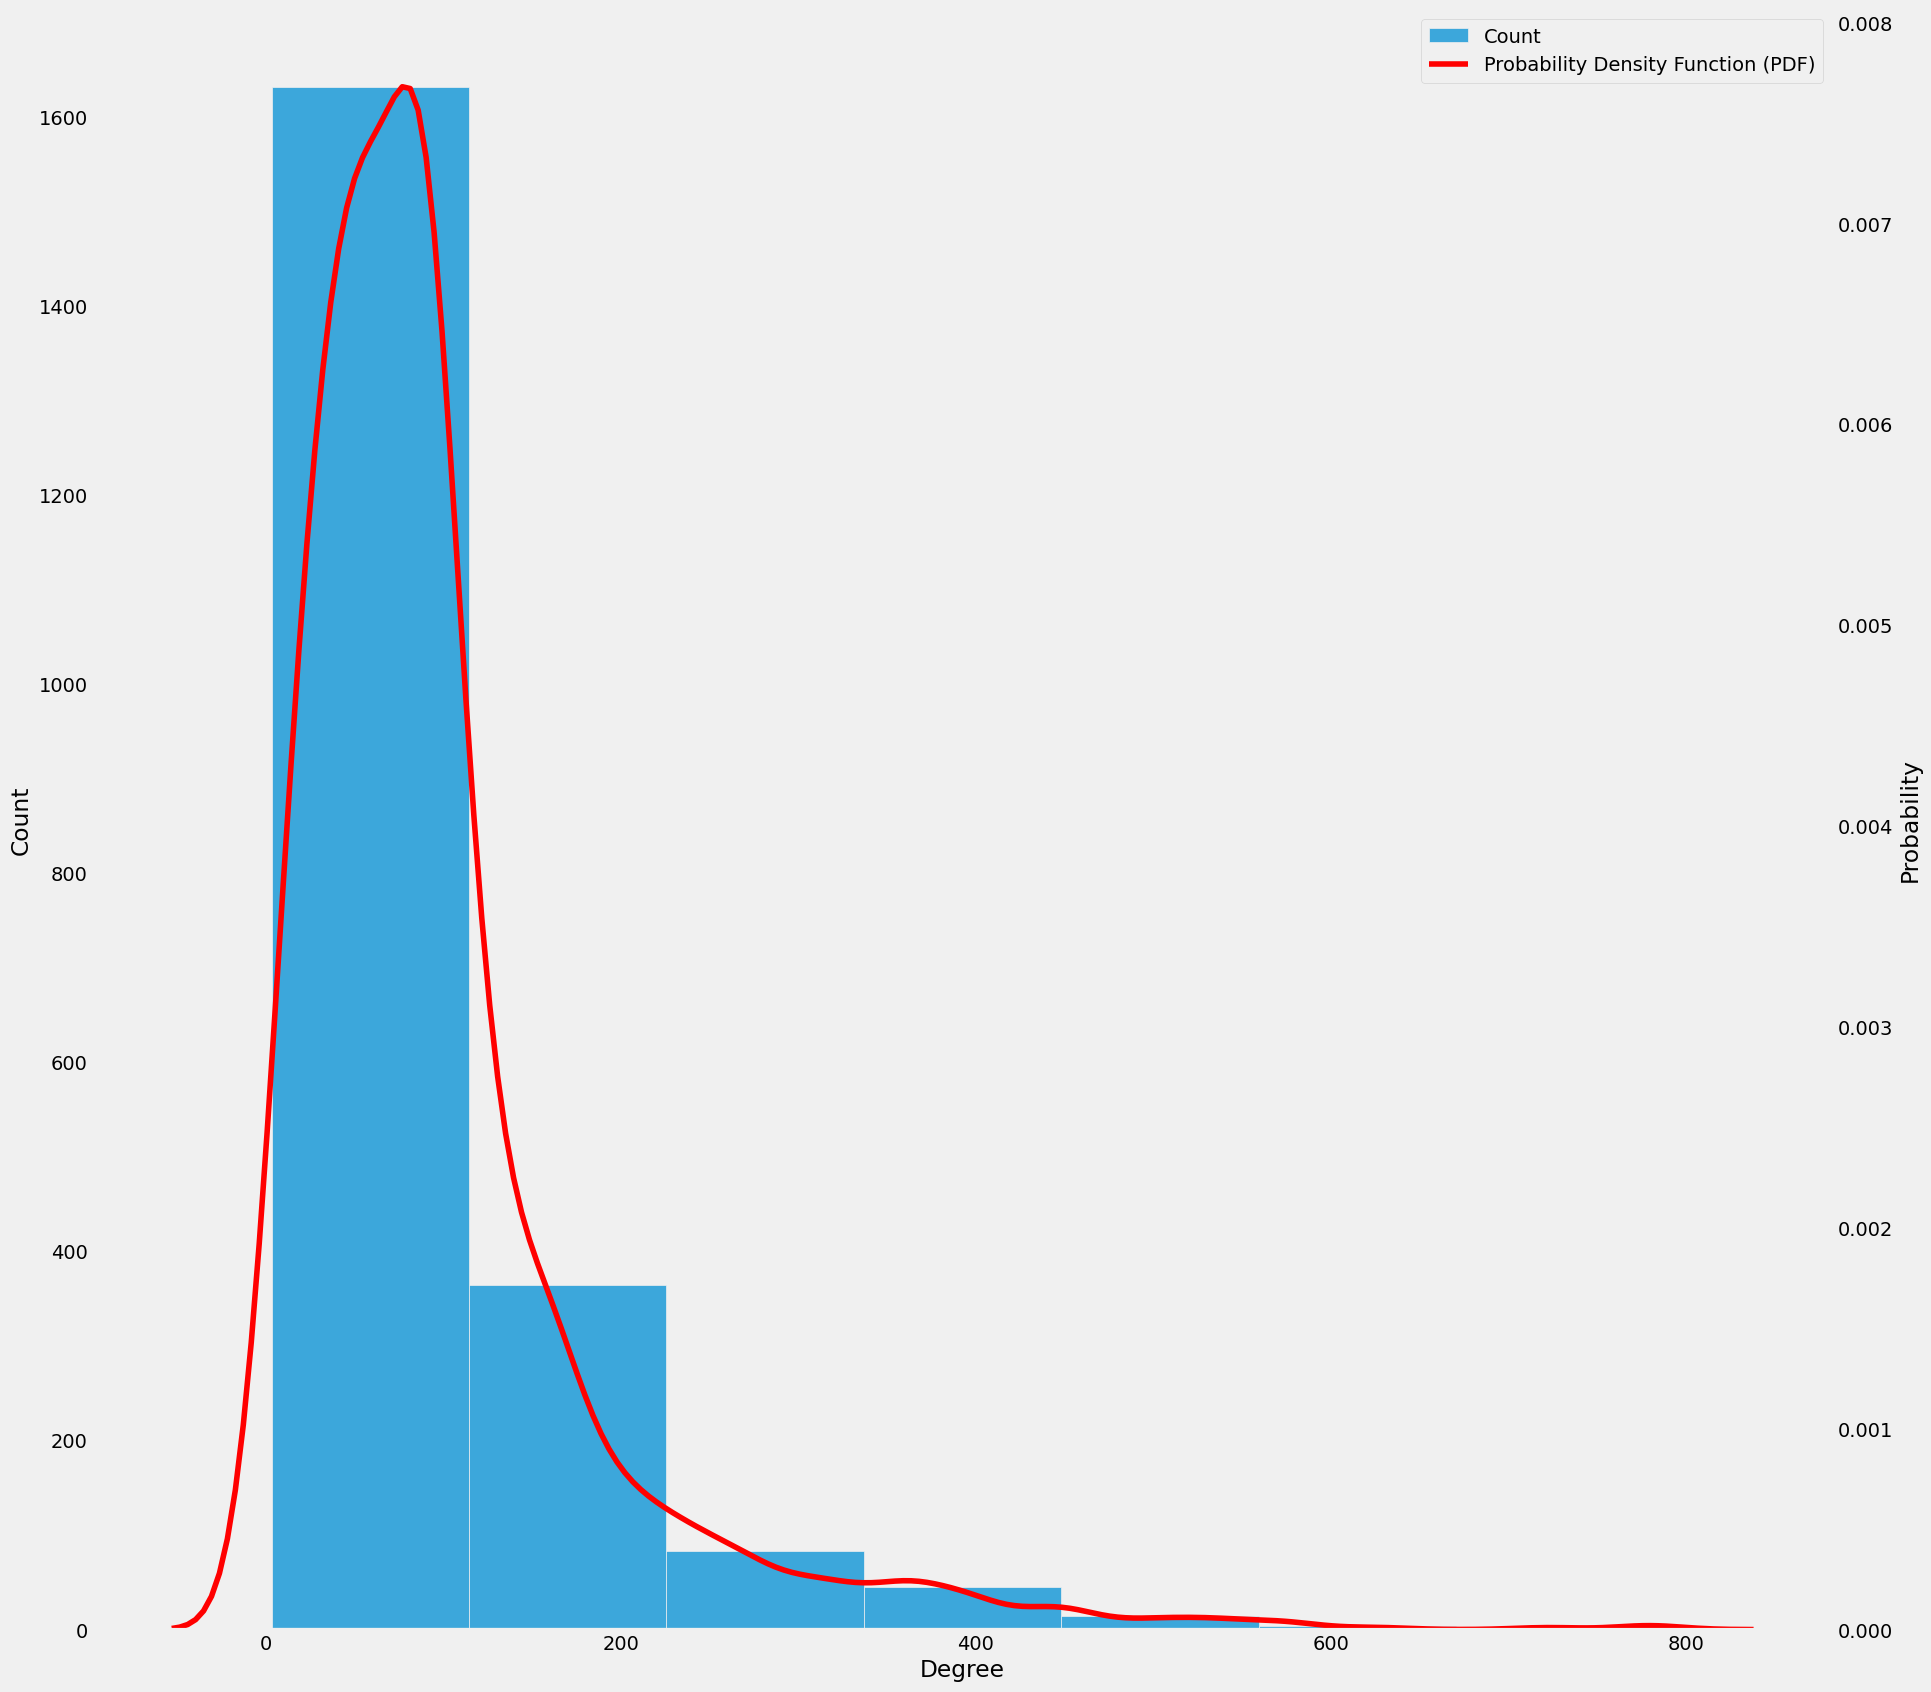

In [ ]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(20,20))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('/content/drive/MyDrive/Redes/results/100/probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

PDF indica uma cauda à esquerda. Como analisado anteriormente, a maioria dos artistas possuem conexões entre seus grupos apenas.

## CDF

In [ ]:
plt.style.use("ggplot")

# Another way to visualize the cumulative distribution
def ecdf(data):
    return np.sort(data), np.arange(1, len(data) + 1) / len(data)

def ecdf_degree(G):
    """ECDF of degree."""
    num_neighbors = [len(list(G.neighbors(n))) for n in G.nodes()]
    x, y = ecdf(num_neighbors)
    plt.scatter(x, y)
    plt.xlabel("degree")
    plt.ylabel("cumulative fraction")

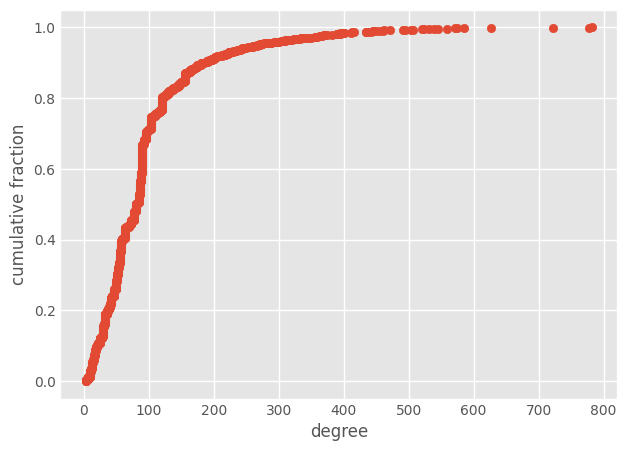

In [ ]:
ecdf_degree(g)

90% de todos os artistas possuem abaixo de 200 conexões, com 70% abaixo de 100.

## K-Core

In [ ]:
# k-core of the network
set([v for k,v in nx.core_number(g).items()])

{3,
 4,
 5,
 6,
 7,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 25,
 28,
 29,
 30,
 31,
 32,
 33,
 36,
 38,
 39,
 40,
 41,
 42,
 44,
 46,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 58,
 59,
 60,
 62,
 63,
 64,
 65,
 69,
 72,
 75,
 77,
 81,
 83,
 84,
 85,
 86,
 88,
 89,
 90,
 95,
 104,
 120,
 121,
 156}

Membros do maior K-Core (156)

In [ ]:
# Change the variable core to visualize the nodes in k-core
# Note that 0-core is the all network
core = 156
for i in nx.k_core(g,core):
  print(i)

Lost Frequencies
Deorro
Aaron Carter
Avicii
Childish Gambino
T-Wayne
Kygo
Kesha
Big Sean
Lilly Wood and The Prick
Nevada
Malea
POWERS
Mike Posner
Justin Bieber
WALK THE MOON
Daft Punk
Pretty Ricky
LunchMoney Lewis
Dawin
Galantis
Natalie La Rose
Mario Vazquez
Coldplay
Nico & Vinz
Kungs
Lady Gaga
Audien
J-Kwon
Edward Maya
FRENSHIP
Joel Adams
Zedd
blackbear
Lorde
DJ Snake
Jason Derulo
Robin Schulz
DJ Khaled
Omar LinX
Kid Cudi
Rudimental
T.I.
French Montana
Imagine Dragons
Axwell /\ Ingrosso
Rihanna
Future
Afrojack
Timeflies
M83
Gucci Mane
DNCE
Vance Joy
Benny Benassi
Alan Walker
Hailee Steinfeld
The Chainsmokers
Zara Larsson
DEAMN
Alx Veliz
Asher Roth
Kiiara
Frances
Usher
Cheat Codes
ALMA
Tove Lo
Olly Murs
Hardwell
KDA
Steve Angello
The Weeknd
Clean Bandit
Drake
Far East Movement
Shoffy
Fifth Harmony
Jonas Blue
Ricky Martin
Shawn Mendes
OMI
Don Omar
G-Eazy
Dante Klein
3OH!3
DR. KUCHO!
Disciples
Ellie Goulding
Nick Jonas
A R I Z O N A
Pleasure P
Mario Winans
Alesso
Marshmello
Boosie Badazz

Grafo dos seguintes K-Cores: 156,121,120,104,95,90,89.

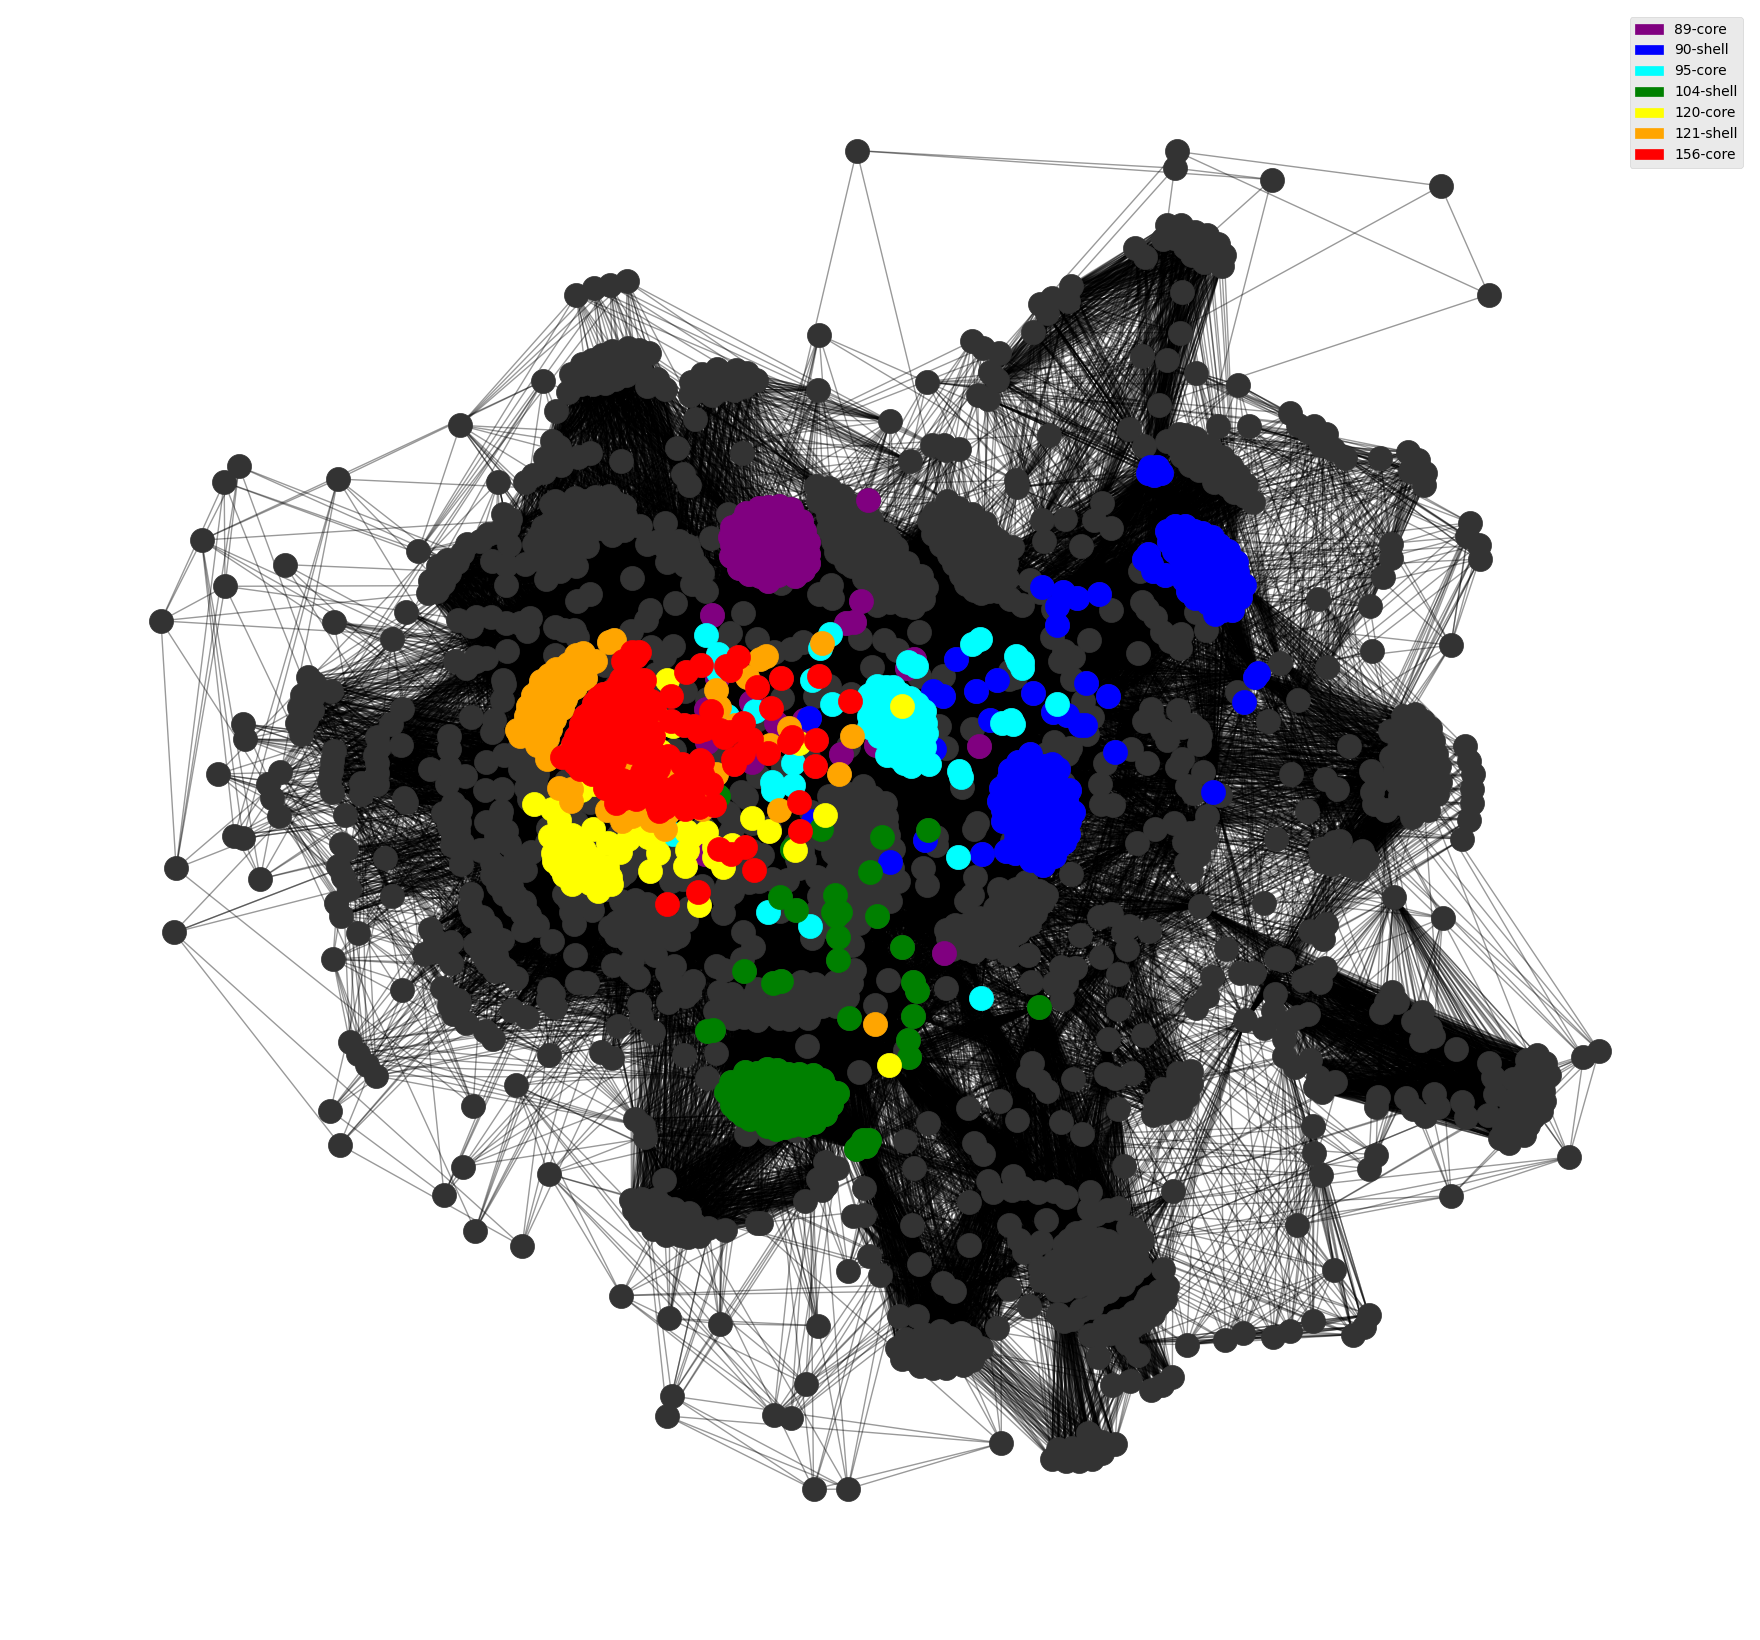

In [ ]:
# the degree of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,20))

# Find k-cores
g_core_7 = nx.k_shell(g, 89)
g_core_6 = nx.k_shell(g, 90)
g_core_5 = nx.k_shell(g, 95)
g_core_4 = nx.k_shell(g, 104)
g_core_3 = nx.k_shell(g, 120)
g_core_2 = nx.k_shell(g, 121)
g_core_1 = nx.k_core(g, 156)


# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color="#333333")

# draw nodes

nodes = nx.draw_networkx_nodes(g_core_7,
                 pos=pos,
                 node_color="purple")

nodes = nx.draw_networkx_nodes(g_core_6,
                 pos=pos,
                 node_color="blue")

nodes = nx.draw_networkx_nodes(g_core_5,
                 pos=pos,
                 node_color="cyan")

nodes = nx.draw_networkx_nodes(g_core_4,
                 pos=pos,
                 node_color="green")

nodes = nx.draw_networkx_nodes(g_core_3,
                 pos=pos,
                 node_color="yellow")

nodes = nx.draw_networkx_nodes(g_core_2,
                 pos=pos,
                 node_color="orange")

nodes = nx.draw_networkx_nodes(g_core_1,
                 pos=pos,
                 node_color="red")

# static legend
purple_patch = mpatches.Patch(color='purple', label='89-core')
blue_patch = mpatches.Patch(color='blue', label='90-shell')
cyan_patch = mpatches.Patch(color='cyan', label='95-core')
green_patch = mpatches.Patch(color='green', label='104-shell')
yellow_patch = mpatches.Patch(color='yellow', label='120-core')
orange_patch = mpatches.Patch(color='orange', label='121-shell')
red_patch = mpatches.Patch(color='red', label='156-core')
plt.legend(handles=[purple_patch,blue_patch,cyan_patch,green_patch,
                    yellow_patch,orange_patch,red_patch])

plt.axis("off")
plt.savefig('/content/drive/MyDrive/Redes/results/100/k-core_sociopatterns.png', transparent=True,dpi=600)
plt.show()

Esse grafo é bem interessante para observar o cluster dos artistas. Nota-se que cada K-Core abaixo de 100 é de artistas próximos entre si. E pontos próximos desse cluster, porém com K-Cores maiores indicam potenciais "Pontes" entre outros grupos.

# Multivariado

In [ ]:
dg_cent = pd.Series(dict(degree_centrality))
eng_cent = pd.Series(dict(eigenvector_centrality))
clo_cent = pd.Series(dict(closeness_centrality))
bet_cent = pd.Series(dict(betweenness_centrality))

In [ ]:
df = pd.concat([dg_cent,eng_cent,clo_cent,bet_cent], axis = 1)

In [ ]:
df.columns = ['Degree','Eigenvector','Closenness','Betwenness']

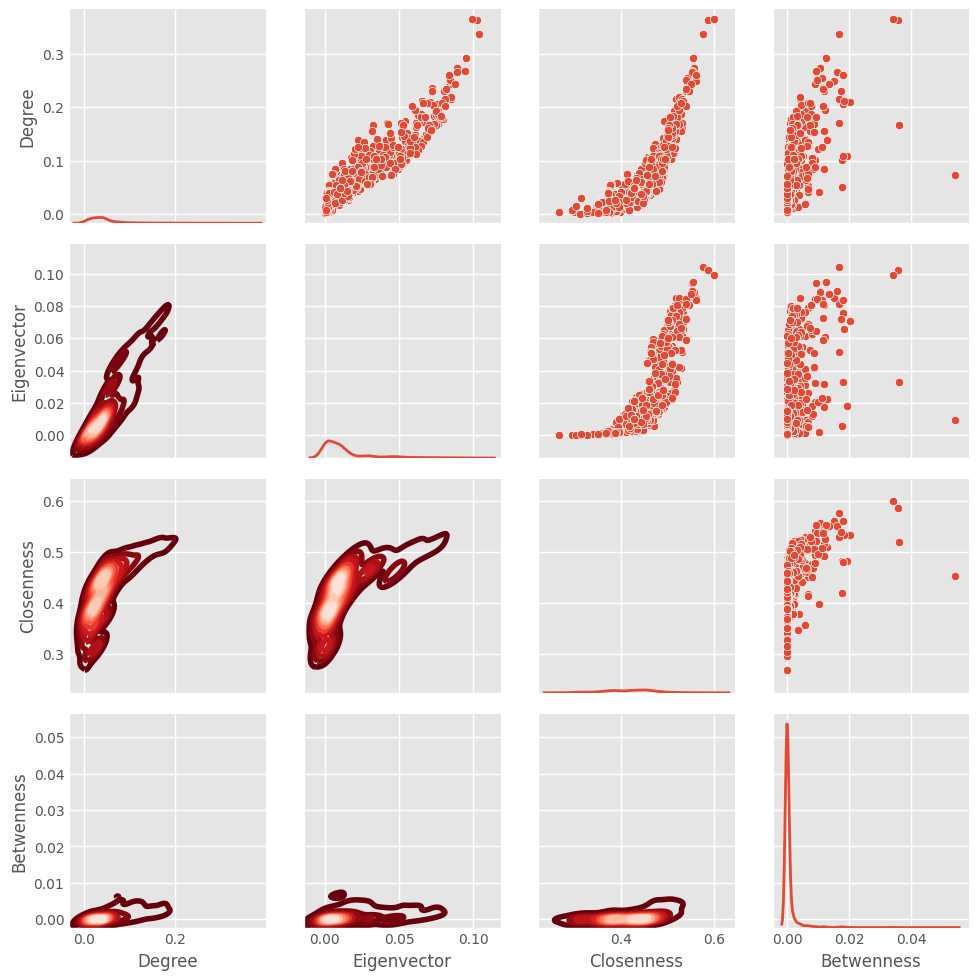

In [ ]:
fig = sns.PairGrid(df)
fig.map_upper(sns.scatterplot)
fig.map_lower(sns.kdeplot, cmap = "Reds_r")
fig.map_diag(sns.kdeplot, lw=2, legend=False)
plt.savefig('/content/drive/MyDrive/Redes/results/100/multivariate_analysis.png', transparent=True,dpi=600)


Betweenness Centrality não aparenta possuir correlação com as demais métricas. Explicado devido à pouca quantidade de artistas que realizam essa "ponte".

Para as demais métricas, observa-se uma relação clara de proporcionalidade.

EigenVector Centrality e Degree aparentam possuir uma relação linear entre si. Isso pode ser explicado que artistas com alto Degree são fortemente conectados entre si. Como todos os "vizinhos importantes" são de um mesmo grupo, seus valores de EigenVector torna-se maior. 

Degree e Closeness aparentam possuir um comportamento levemente exponencial/quadrático. Novamente, Degrees altos são indicativos de maior facilidade de chegar a qualquer pontos da rede, tornando a métrica de Closeness maior. Nesse caso, maiores degrees podem acarretar em ligações com pontos de maior betwenness, facilitando mais ainda o caminho aos pontos distantes.

Por fim, EigenVector Centrality e Closeness Centrality também possuem o mesmo comportamento. Artistas mais próximos do centro possuem maiores conexões entre si e, por consequência, seus vizinhos são mais importantes também. 

# Salvar o grafo

In [ ]:
nx.write_graphml(g,'/content/drive/MyDrive/Redes/results/100/graph_artist.graphml')